# # Titanic: Machine Learning from Disaster

- The goal of the task is to predict who survived on the test set having trained the prediction model on the training set.
- Please, take into consideration that some features have missing values: you need to perform data cleaning  and perform imputation for the missing values.
- Train and compare prediction accuracy for at least 3 different prediction models of your choice.
- Consider also performing some preprocessing steps, such as discretisation of continuous features or calibration into numerical values of categorical ones.

Hints:
Consider that female, children and people with first class tickets were embarked on lifeboats first and survived more easily. 

In [2083]:
import numpy as np
import math
import scipy as sc
import pandas as pd
import seaborn as sns
import statistics as stat
import matplotlib.pyplot as plt
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Dataset loading

In [2084]:
train = pd.read_csv('./titanic_training.csv')
test = pd.read_csv('./titanic_test.csv')
test_target_true = pd.read_csv('./titanic_test_set_ground_truth.csv')
train.shape, test.shape

((891, 12), (418, 11))

In [2085]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2086]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [2087]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2088]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Features missing values

Visualize missing values using heatmap

In [2089]:
def visualize_missing_values():
    f,ax = plt.subplots(1,2,figsize=(15,3))
    sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[0])
    sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[1])
    plt.show()

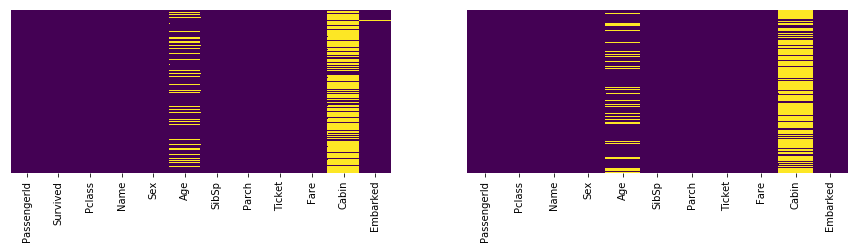

In [2090]:
visualize_missing_values()

We remove the attribute related to the ticket

In [2091]:
train.drop('Ticket',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)

Set 'No cabin' to match the missing attribute

In [2092]:
train['Cabin'].fillna('No Cabin',inplace=True)
test['Cabin'].fillna('No Cabin',inplace=True)

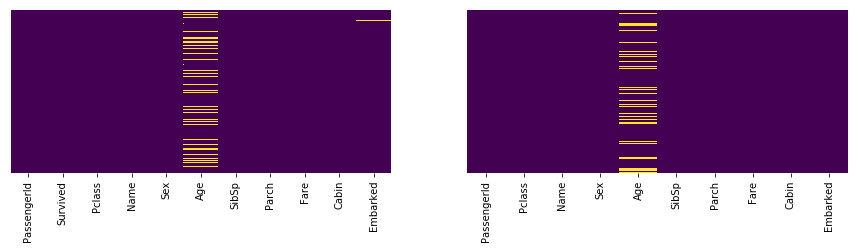

In [2093]:
visualize_missing_values()

Visualize the instance with missing values for the Embarked attribute 

In [2094]:
train[train["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,B28,NaN


Considering that the two examples are female and both have survived and belonging to the first class, we graphically visualize the correlation of the features

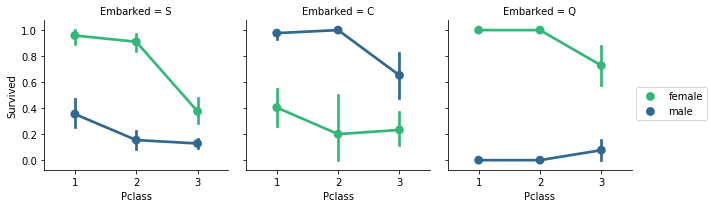

In [2095]:
g = sns.FacetGrid(col='Embarked',data=train)
g.map(sns.pointplot,'Pclass','Survived','Sex',palette='viridis')
g.add_legend()
plt.show()

Observing that both persons with null boarding are women, survivors and belonging to the same class. And observing that all the first-class women embarked in Q have survived we can infer that the missing values ​​are Q

In [2096]:
train['Embarked'].fillna('Q',inplace=True)

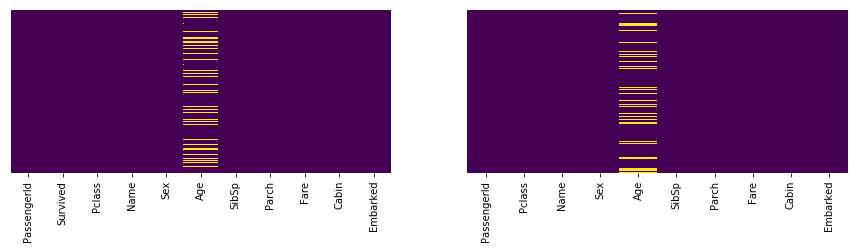

In [2097]:
visualize_missing_values()

Visualize the instance with missing values for the Fare attribute

In [2098]:
test[test["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,No Cabin,S


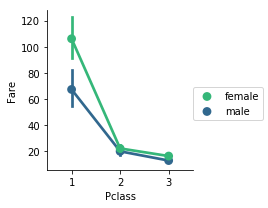

In [2099]:
g = sns.FacetGrid(data=train)
g.map(sns.pointplot,'Pclass','Fare','Sex',palette='viridis')
g.add_legend()
plt.show()

We can calculate the average Fare for passengers of class 3 and fill the missing value

In [2100]:
class_3_fare_mean = stat.mean(test.loc[test['Pclass'] == 3].loc[test['Fare'].notnull()]['Fare'])
test['Fare'].fillna(class_3_fare_mean, inplace=True)

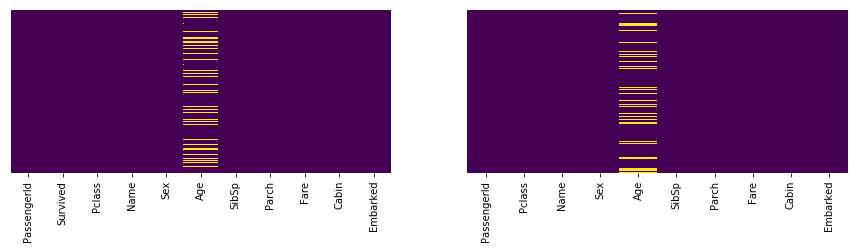

In [2101]:
visualize_missing_values()

We estimate the missing age values with a predictive model

In [2102]:
def process_dummies(df,cols):
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col,drop_first=True)
        df = pd.concat([df.drop(col,axis=1),dummies],axis=1)
    return df

In [2103]:
def predict_missing_age(data):
    tmpData = data.copy()
    tmpData = process_dummies(tmpData,['Embarked','Sex'])
    tmpData.drop(['Name','Cabin'],axis=1,inplace=True)
    
    X = tmpData.loc[tmpData['Age'].notnull()]
    y = X['Age']
    X = X[tmpData.columns.difference(['Age'])]
    
    clf = SVR()
    clf.fit(X, y)
    X_pred = tmpData.loc[tmpData['Age'].isnull()][tmpData.columns.difference(['Age'])]
    data.loc[data['Age'].isnull(),'Age'] = clf.predict(X_pred)

In [2104]:
predict_missing_age(train)
predict_missing_age(test)

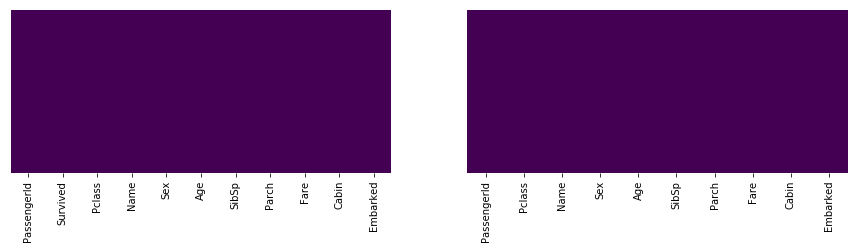

In [2105]:
visualize_missing_values()

# Adding new feature to data

Define the feature 'isAlone' if a person travel alone

In [2106]:
def calculate_alone_passengers(data):
    data.loc[(data['SibSp'] + data['Parch'] + 1 )==1, 'IsAlone'] = 1
    data['IsAlone'].fillna(0, inplace=True)
    data.drop(['SibSp','Parch'],axis=1,inplace=True)

In [2107]:
calculate_alone_passengers(train)
calculate_alone_passengers(test)

Showing the plot of the number of survivors in relation to whether they were alone or not

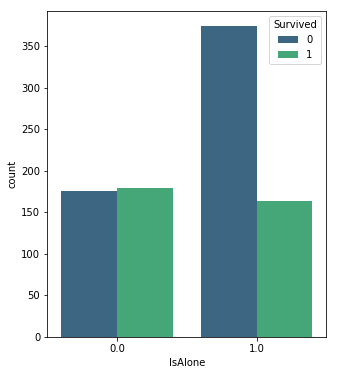

In [2108]:
f,ax = plt.subplots(figsize=(5,6))
sns.countplot(train['IsAlone'],hue=train['Survived'],palette='viridis')
plt.show()

We transform the feature containing the name, extracting the title

In [2109]:
def transform_name(df):
    df['Title'] = df['Name'].str.split(', ').str[1].str.split('.').str[0]
    df.drop('Name',axis=1,inplace=True)
    df['Title'].replace('Mme','Mrs',inplace=True)
    df['Title'].replace(['Ms','Mlle'],'Miss',inplace=True)
    df['Title'].replace(['Dr','Rev','Col','Major','Dona','Don','Sir','Lady','Jonkheer','Capt','the Countess'],'Others',inplace=True)

In [2110]:
transform_name(train)
transform_name(test)

In [2111]:
print train['Title'].value_counts() 

Mr        517
Miss      185
Mrs       126
Master     40
Others     23
Name: Title, dtype: int64


The structure of the dataset after the changes results

In [2112]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,IsAlone,Title
0,1,0,3,male,22.0,7.2500,No Cabin,S,0.0,Mr
1,2,1,1,female,38.0,71.2833,C85,C,0.0,Mrs
2,3,1,3,female,26.0,7.9250,No Cabin,S,1.0,Miss
3,4,1,1,female,35.0,53.1000,C123,S,0.0,Mrs
4,5,0,3,male,35.0,8.0500,No Cabin,S,1.0,Mr


We modify the cabin, taking advantage of the initial letter

In [2113]:
def transform_cabin(df):
    df['Deck'] = df['Cabin']
    df.loc[df['Deck']!='No Cabin','Deck'] = df[df['Cabin']!='No Cabin']['Cabin'].str[0]
    df.loc[df['Deck']=='No Cabin', 'Deck'] = 0
    df.loc[df['Deck']=='G', 'Deck'] = 1
    df.loc[df['Deck']=='F', 'Deck'] = 2
    df.loc[df['Deck']=='E', 'Deck'] = 3
    df.loc[df['Deck']=='D', 'Deck'] = 4
    df.loc[df['Deck']=='C', 'Deck'] = 5
    df.loc[df['Deck']=='B', 'Deck'] = 6
    df.loc[df['Deck']=='A', 'Deck'] = 7
    if 'T' in df['Deck'].values :
        df.loc[df['Deck']=='T', 'Deck'] = 0
    df.drop('Cabin',axis=1,inplace=True)

In [2114]:
transform_cabin(train)
transform_cabin(test)

/Users/gabriele/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [2115]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title,Deck
0,1,0,3,male,22.0,7.2500,S,0.0,Mr,0
1,2,1,1,female,38.0,71.2833,C,0.0,Mrs,5
2,3,1,3,female,26.0,7.9250,S,1.0,Miss,0
3,4,1,1,female,35.0,53.1000,S,0.0,Mrs,5
4,5,0,3,male,35.0,8.0500,S,1.0,Mr,0


# Features normalization

In [2116]:
def normalize_features(df):
    scaler = MinMaxScaler()
    df[['Fare','Pclass','Age','Deck']] = scaler.fit_transform(df[['Fare','Pclass','Age','Deck']])

In [2117]:
normalize_features(train)
normalize_features(test)

In [2118]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title,Deck
0,1,0,1.0,male,0.271174,0.014151,S,0.0,Mr,0.000000
1,2,1,0.0,female,0.472229,0.139136,C,0.0,Mrs,0.714286
2,3,1,1.0,female,0.321438,0.015469,S,1.0,Miss,0.000000
3,4,1,0.0,female,0.434531,0.103644,S,0.0,Mrs,0.714286
4,5,0,1.0,male,0.434531,0.015713,S,1.0,Mr,0.000000


# Transformation of categorical features

In [2119]:
def transform_categorical(df):
    return process_dummies(df,['Embarked','Sex','Title'])

In [2120]:
train = transform_categorical(train)
test = transform_categorical(test)

In [2121]:
train.head()

,PassengerId,Survived,Pclass,Age,Fare,IsAlone,Deck,Embarked_Q,Embarked_S,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Others
0,1,0,1.0,0.271174,0.014151,0.0,0.000000,0,1,1,0,1,0,0
1,2,1,0.0,0.472229,0.139136,0.0,0.714286,0,0,0,0,0,1,0
2,3,1,1.0,0.321438,0.015469,1.0,0.000000,0,1,0,1,0,0,0
3,4,1,0.0,0.434531,0.103644,0.0,0.714286,0,1,0,0,0,1,0
4,5,0,1.0,0.434531,0.015713,1.0,0.000000,0,1,1,0,1,0,0


In [2122]:
train.drop(['PassengerId'],axis=1,inplace=True)
test.drop(['PassengerId'],axis=1,inplace=True)

In [2123]:
train.head()

,Survived,Pclass,Age,Fare,IsAlone,Deck,Embarked_Q,Embarked_S,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Others
0,0,1.0,0.271174,0.014151,0.0,0.000000,0,1,1,0,1,0,0
1,1,0.0,0.472229,0.139136,0.0,0.714286,0,0,0,0,0,1,0
2,1,1.0,0.321438,0.015469,1.0,0.000000,0,1,0,1,0,0,0
3,1,0.0,0.434531,0.103644,0.0,0.714286,0,1,0,0,0,1,0
4,0,1.0,0.434531,0.015713,1.0,0.000000,0,1,1,0,1,0,0


# Testing classifier

In [2124]:
def test_classifier(clf):
    clf.fit(train[train.columns.difference(['Survived'])], train['Survived'])
    y_pred = clf.predict(test)
    print "Accuracy (Train set): %s" % accuracy_score(train['Survived'], clf.predict(train[train.columns.difference(['Survived'])]))
    print "Accuracy (Test set): %s" % accuracy_score(test_target_true['Survived'], y_pred)

# SVC

In [2125]:
clf = SVC()
test_classifier(clf)

Accuracy (Train set): 0.791245791246
Accuracy (Test set): 0.995215311005


# DecisionTreeClassifier

In [2126]:
clf = DecisionTreeClassifier()
test_classifier(clf)

Accuracy (Train set): 0.99214365881
Accuracy (Test set): 0.557416267943


# RandomForestClassifier

In [2127]:
clf = RandomForestClassifier()
test_classifier(clf)

Accuracy (Train set): 0.976430976431
Accuracy (Test set): 0.736842105263


# Gaussian NB

In [2128]:
clf = GaussianNB()
test_classifier(clf)

Accuracy (Train set): 0.780022446689
Accuracy (Test set): 0.875598086124
